In [2]:
"""
Created on Wed Apr 13 20:57:44 2022
@author: lfsto
"""


#----#----#----#----#----#----#----#----#----#----#----#----#
#----#
#----# Exectute this file, 
#----# Then run run_model() with parameters for 
#----#   the spatial resolution, the time steps, and frequency cutoff.
#----# Then run gif(), no parameters
#----#
#----# Note that gif() will save files to your computer! 
#----# GIF() WILL SAVE FILES TO YOUR COMPUTER!!!!!
#----# GIF() WILL SAVE HUNDREDS OF FILES TO YOUR COMPUTER!!!!!!
#----# It will save hundreds of files, 
#----# then delete them all (assuming it fully executes), then save 
#----# one final .gif
#----#
#----#----#----#----#----#----#----#----#----#----#----#----#


#%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import time
import os
import imageio

##### Solving the flow #####

def flow(u, x, odestep, h, steps):
	'''
	  u: vector field
	  x: n-by-2 array of initial conditions where n is the grid size
	  odestep: numerical method for solving ode
	  h: step size for numerical method
	  steps: total number of steps to take
	  The algorithm returns Points which is a steps-by-n-by-2 array.
	  Points[i,j,k] is the value of the kth coordinate of the jth point
	  at the ith time step. 
	'''
	Points = np.empty((steps,*x.shape))
	Points[0] = x
	for i in range(1,steps):
		x = odestep(u,x,h)
		x = x - np.floor(x)
		Points[i] = x
	return Points


##### ODE solvers #####

# Euler
def euler(u,x,h):
	return x + h * u(*x)

# Runge-Kutta 4
def rk4(u,x,h):
	k1 = u(*x)
	k2 = u(*(x + (h/2) * k1))
	k3 = u(*(x + (h/2) * k2))
	k4 = u(*(x + h * k3))
	return x + (h/6) * (k1 + 2.*(k2 + k3) + k4)


##### Vector field #####
'''
# At a point
def u_point(x):
	return np.array([x[1], -x[0]])
# Over the whole space
def u(x):
	return np.array([u_point(xi) for xi in x])
'''

##### Initial data #####

def initial(x):
	initial_vals = np.ones_like(x)
	for i in np.ndindex(x.shape):
		if x[i] > 0.5:
			initial_vals[i] = 0.
	return initial_vals

def sin(x):
    z = 2*(x%1)-1
    return sum([(-1)**(n//2) * np.pi**n * z**n / np.math.factorial(n) for n in range(1,20,2)])

def cos(x):
    z = 2*(x%1)-1
    return sum([(-1)**(n//2+1) * np.pi**n * z**n / np.math.factorial(n) for n in range(0,20,2)])


def make_field(n):
    const = np.random.rand(2)*2-1
    coeff = np.random.rand(n,n,4)*2-1
    
    def velocity(x, y):
        total = np.array([np.full_like(x,const[0]),np.full_like(x,const[1])])
        
        cos_x_vals = {}
        sin_x_vals = {}
        cos_y_vals = {}
        sin_y_vals = {}
        
        for i in range(n):
            cos_x_vals[i] = cos(i*x)
            sin_x_vals[i] = sin(i*x)
        for j in range(n):
            cos_y_vals[j] = cos(j*y)
            sin_y_vals[j] = sin(j*y)
        
        for i,j in zip(range(n),range(n)):
            size_opp = (coeff[i,j,0] * (sin_x_vals[i] * sin_y_vals[j] - cos_x_vals[i]*cos_y_vals[j])
                      + coeff[i,j,1] * (sin_x_vals[i] * cos_y_vals[j] + cos_x_vals[i]*sin_y_vals[j])
                      ) / (1+i**2+j**2)
            size_same= (coeff[i,j,2] * (sin_x_vals[i] * sin_y_vals[j] + cos_x_vals[i]*cos_y_vals[j])
                      + coeff[i,j,3] * (sin_x_vals[i] * cos_y_vals[j] - cos_x_vals[i]*sin_y_vals[j])
                      ) / (1+i**2+j**2)
            total += [j*(size_same - size_opp), i*(size_same+size_opp)]
        
        return total
    
    return velocity




def run_model(grid_resolution, frequency_range, num_time_steps):
    global u, points,grid,initial_vals,h,steps,n,freq
    n = grid_resolution
    freq = frequency_range
    grid = np.array(np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n)))
    initial_vals = initial(grid[0])
    h = 0.01
    steps = num_time_steps
    
    
    u = make_field(frequency_range)
    points = flow(u, grid, rk4, h, steps)


### Animation ###
'''
fig, ax = plt.subplots(1, 1)
colors = np.where(initial_vals.flatten()==1,'yellow','black')
scatter = ax.scatter(points[0,0].flatten(), points[0, 1].flatten(), s=3, c=colors)
def update(i):
   scatter.set_offsets(points[i,0].flatten(),points[i,1].flatten())
   return scatter,
anim = FuncAnimation(fig, update, frames=steps, interval=10, repeat=True)
#anim.save('Simulation3.mp4', fps=30)
plt.show()
'''


def gif():    #(x_vals, y_vals):
    filenames = []
    save_as = f"Users/danielblock/Desktop/Duke/Sophomore Year/RTG_{time.strftime('%Y-%m-%d-%H.%M.%S')}.gif"
    
    fig, ax = plt.subplots(1, 1)
    
    colors = np.where(initial_vals.flatten()==1,'yellow','black')
    scatter = ax.scatter(points[0,0].flatten(), points[0, 1].flatten(), s=3, c=colors)
    ax.set_title(f"resolution {n}, u frequencies up to {freq}")
    
    for i in range(steps):
        data = list(map(list,zip(points[i,0].flatten(),points[i,1].flatten())))
        
        scatter.set_offsets(data) #np.c_[data[::2], data[1::2]])
        filename = f"temp_image_{i}.png"
        filenames.append(filename)
        fig.savefig(filename)
        #fig.close()
    # build gif
    with imageio.get_writer(save_as, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [20]:
run_model(512, 5, 200)

In [ ]:
gif()

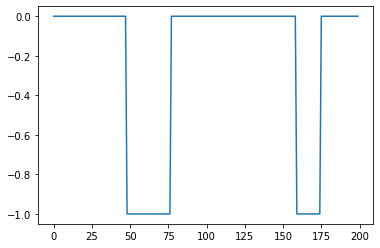

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# #there are 2**2N squares of size 2**-N x 2**-N
# def mixing_scale(x_data, y_data, kappa):
#     array_Size = x_data.shape[0];
#     array_Size = array_Size/2;
#     N = 1;
#     while(True):
#         mesh_size = 1/(2**N);
#         x = 0;
#         for i in range(2**N):
#             y = 0;
#             for k in range(2**N):
#                 function_Values = 0
                
#                 #this needs to change to fit data format
#                 x_matches = np.where(np.logical_and(x_data>=x, x_data<(x+mesh_size)));
#                 x_array = x_matches[0];
#                 #print(x, x+mesh_size);
                
                
#                 y_matches = np.where(np.logical_and(y_data>=y, y_data<(y+mesh_size)));
#                 y_array = y_matches[0];
#                 #print(y, y+mesh_size);
                
#                 matches = set(x_array) & set(y_array);
#                 numPoints = len(matches);
#                 #print(matches)
                
#                 if numPoints == 0:
#                     #print("Empty cell");
#                     break;
                
#                 for points in matches:
#                     #print(points.shape);
#                     if(points <= array_Size):
#                         function_Values += 1;
#                     else:
#                         function_Values -= 1;
        
#                 if abs(function_Values/numPoints) > 1/kappa:
#                     return 1/(2**(N-1));
                
#                 y += mesh_size;     
                
#             x += mesh_size;
            
#         N = N+1;
#         #print(f"The iteration is {N}.");

def mixing_scale(grid, t, kappa):

    # Size of grid (e.g. if grid is 64-by-64 then N=64)
    N = grid[0,0,:,:].shape[0]

    # Resolution of grid (e.g. if grid is 64-by-64 then R=log_2(64)=6 since 64=2**6)
    R = np.log2(N)

    # Print warning if grid size is not a power of 2
    if R.is_integer() == False:
        print('Warning: Grid size should be a power of 2.')

    # x and y coordinates from left half of grid (points corresponding to +1)
    X_left = grid[t, 0, :int(N/2), :]
    Y_left = grid[t, 1, :int(N/2), :]

    # x and y coordinates from right half of grid (points corresponding to -1)
    X_right = grid[t, 0, int(N/2):, :]
    Y_right = grid[t, 1, int(N/2):, :]

    # Flatten to make into 2d histogram
    X_left = X_left.flatten()
    Y_left = Y_left.flatten()
    X_right = X_right.flatten()
    Y_right = Y_right.flatten()

    n = 0
    Mixed = True
    while(n <= R and Mixed == True):

        '''
        Normalizing factor, i.e. number of points per square. The variable Z is
        commonly used for normalizing factors in probability/statistical mechanics.
        '''
        Z = 2**(2*(R-n))

        '''
        2d histogram of points that start in left and right of grid. Ignore xedges and
        yedges, the important objects are Left and Right.
        '''
        Left, xedges, yedges = np.histogram2d(X_left, Y_left, bins=int(2**n), range=[[0,1], [0,1]])
        Right, xedges, yedges = np.histogram2d(X_right, Y_right, bins=int(2**n), range=[[0,1], [0,1]])

        # Check if mixed to scale 2**(-n)
        A = Left-Right
        a = np.max(np.abs((1/Z)*A))
        if a <= 1/kappa:
            scale = 2**(-n)
            #print('Mixed to scale', 2**(-n))
        else:
            Mixed = False

        n += 1

    return scale

grid = points
kappa = 3

Scale = np.empty(200)
for t in range(200):
    Scale[t] = mixing_scale(grid, t, kappa)

plt.plot(np.log2(Scale))
plt.show()

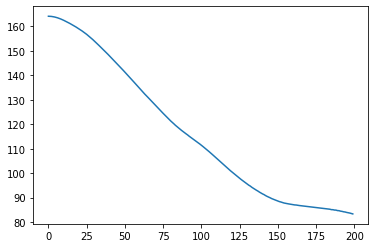

In [18]:
import numpy as np
from scipy.fft import fft
from scipy.interpolate import griddata
import cmath as cm
import matplotlib.pyplot as plt

data = points
res = 512

def initial(x):
    ini = np.ones((res, res))
       #ini1, ini2 = np.meshgrid(np.linspace(1,1,512), np.linspace(1,1,512))
    for i in range(res):
        if i >= res/2:
            ini[i] = 0.
                #ini2[i] = 0.
    return ini

def h1(data, t, res):
    #t must be less than the total number of timesteps
    # define grid points
    #data = np.load(data)
    data1 = data[t][0]
    data2 = data[t][1]
    datanew = initial(data1).flatten()
    x, y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    dn = griddata((data1.flatten(), data2.flatten()), (datanew), (x, y), 'nearest').reshape(res,res)
    # take fft of the points
    data_ff = np.fft.fft2(dn-np.mean(dn))
    xn = np.zeros((res,res))
    # divide them by sqrt of j^2 + k^2 (where j and k are the indices of the array of grid points)
    for j in range(res):
        for k in range(res):
            if (j**2+k**2 != 0):
                xn[j,k] = abs(data_ff[j, k] / cm.sqrt((j**2) + (k**2)))
            if (j==0 & k == 0):
                xn[0,0] = abs(data_ff[0,0])
    #this does skip the pair (0,0), which stays at zero, so i just added the original data_ff(0,0) unchanged
    # square points, sum them all, and take sqrt again
    xn1 = xn**2
    #xn1 is a two dimensional array, NxN based on dimensions of the grid
    x2 = sum(sum(xn1))/(res**2)
    #total sum of all NxN elements
    xf = np.sqrt(x2)
    return xf


h1norms = h1(data, 0, 512)
#print(h1norms)

Scale = np.empty(200)
for t in range(200):
    Scale[t] = h1(data, t, res)
    
plt.plot(Scale)
plt.show()